Data source: https://www.ncei.noaa.gov/cdo-web/
* Daily summary for weather station: 'CHICAGO MIDWAY AIRPORT, IL US'

# Initializing Notebook

In [25]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score

In [3]:
# Import data, remove NANs, split date into separate columns for year, month, day
df = pd.read_csv('data/noaa_midway_1997-05-01_2025-07-18.csv')
df = df[['DATE', 'AWND', 'PRCP', 'TMAX', 'TMIN', 'WDF2', 'WDF5', 'WSF2', 'WSF5']]
df = df.dropna()
df['DATE'] = pd.to_datetime(df['DATE'])
df['year'] = df['DATE'].dt.year
df['month'] = df['DATE'].dt.month
df['day'] = df['DATE'].dt.day
df.head()

,DATE,AWND,PRCP,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,year,month,day
331,1998-04-01,13.42,0.20,49.0,39.0,260.0,200.0,25.9,33.1,1998,4,1
332,1998-04-02,8.95,0.01,49.0,39.0,280.0,290.0,17.0,21.0,1998,4,2
333,1998-04-03,14.54,0.00,44.0,39.0,30.0,20.0,25.1,32.0,1998,4,3
334,1998-04-04,15.43,0.00,50.0,37.0,30.0,40.0,28.0,32.0,1998,4,4
335,1998-04-05,6.71,0.00,52.0,31.0,20.0,30.0,15.0,17.0,1998,4,5


In [5]:
# Split training and testing data
X = df.drop(['DATE', 'PRCP'], axis=1)
y = df['PRCP']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Basic Regression Models

In [7]:
# Linear regression models with polynomial degree 1-5

# Create empty lists of training and test mean squared errors
train_mses = []
test_mses = []

# For loop to iterate over each polynomial degree
for i in range(1,5):
    # Pipeline for linear regression
    pipe = Pipeline([
        ('polyfeatures', PolynomialFeatures(degree=i)),
        ('scaler', StandardScaler()),
        ('linreg', LinearRegression())
    ])
    # Fit the model on training data
    pipe.fit(X_train, y_train)
    # Make predictions for training and test data
    p1 = pipe.predict(X_train)
    p2 = pipe.predict(X_test)
    # Mean squared errors calculated for train and test sets
    train_mses.append(mean_squared_error(y_train, p1))
    test_mses.append(mean_squared_error(y_test, p2))

# Cross validation
# Create dataframe with training and test mean squared errors for each value of K (polynomial degree)
k_values = np.array(range(1,5))
MSEs_w_k = pd.DataFrame({"k": k_values, "Train MSE": train_mses, "Test MSE": test_mses})
MSEs_w_k

,k,Train MSE,Test MSE
0,1,0.066567,0.065678
1,2,0.062606,0.065420
2,3,0.056257,0.070986
3,4,0.045321,0.646208


In [9]:
# Instantiating several more basic regression models to compare performance
lin1 = Pipeline([
    ('polyfeatures', PolynomialFeatures(degree=1)),
    ('scaler', StandardScaler()),
    ('linreg', LinearRegression())
])


lin2 = Pipeline([
    ('polyfeatures', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler()),
    ('linreg', LinearRegression())
])

ridge = Pipeline([
    ('polyfeatures', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

lasso = Pipeline([
    ('polyfeatures', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler()),
    ('lasso', Lasso())
])

# Creating dictionary for model names to be displayed in DataFrame
model_dict = {lin1: "Linear Regression Degree 1",
              lin2: "Linear Regression Degree 2",
              ridge: "Ridge Regression",
              lasso: "Lasso Regression"}

In [11]:
# Creating a function to evaluate runtime, training accuracy, and test accuracy for a list of un-fitted models
def model_checker(models):
    # Empty lists to append after iterating through each model
    model_names = []
    train_times = []
    train_mses = []
    test_mses = []

    # Looping over each model from list
    for model in models:
        # Training model and calculating runtime
        start_time = time.time()
        model.fit(X_train, y_train)
        end_time = time.time()

        # Computing training and test accuracy
        train_mse = mean_squared_error(y_train, model.predict(X_train))
        test_mse = mean_squared_error(y_test, model.predict(X_test))

        # Adding information to lists
        model_names.append(model_dict[model])
        train_times.append(end_time - start_time)
        train_mses.append(train_mse)
        test_mses.append(test_mse)

    # Create data frame with each list as a column
    summary = pd.DataFrame({'Model': model_names,
                            'Train Time (s)': train_times,
                            'Train MSE': train_mses,
                            'Test MSE': test_mses})
    # Display data frame
    display(summary)

In [13]:
# Checking basic regression model performance
models = [lin1, lin2, ridge, lasso]

model_checker(models)

,Model,Train Time (s),Train MSE,Test MSE
0,Linear Regression Degree 1,0.008998,0.066567,0.065678
1,Linear Regression Degree 2,0.034991,0.062606,0.065420
2,Ridge Regression,0.038235,0.063001,0.064980
3,Lasso Regression,0.020993,0.077529,0.073681


In [17]:
# GridSearchCV for degree 2 linear regression
lin2_param_space = {'linreg__copy_X': [True,False], 
               'linreg__fit_intercept': [True,False], 
               'linreg__n_jobs': [1,5,10,15,None], 
               'linreg__positive': [True,False]}

lin2_grid_search = GridSearchCV(lin2, lin2_param_space, cv=5)
lin2_grid_search.fit(X_train, y_train)

lin2_best = lin2_grid_search.best_estimator_
lin2_best_test_mse = mean_squared_error(y_test, lin2_best.predict(X_test))

# Parameter which gives the best results
print(f"Best Hyperparameters: {lin2_grid_search.best_params_}")

# Accuracy of the model after using best parameters
print(f"Best MSE: {lin2_best_test_mse}")

Best Hyperparameters: {'linreg__copy_X': True, 'linreg__fit_intercept': True, 'linreg__n_jobs': 1, 'linreg__positive': False}
Best MSE: 0.06541975858339272


In [19]:
# GridSearchCV for ridge regression
ridge_param_space = {'ridge__alpha': 10**np.linspace(-4, 3, 10),
                     'ridge__fit_intercept': [True, False]}

ridge_grid_search = GridSearchCV(ridge, ridge_param_space, cv=5)
ridge_grid_search.fit(X_train, y_train)

ridge_best = ridge_grid_search.best_estimator_
ridge_best_test_mse = mean_squared_error(y_test, ridge_best.predict(X_test))

# Parameter which gives the best results
print(f"Best Hyperparameters: {ridge_grid_search.best_params_}")

# Accuracy of the model after using best parameters
print(f"Best MSE: {ridge_best_test_mse}")

Best Hyperparameters: {'ridge__alpha': 0.1291549665014884, 'ridge__fit_intercept': True}
Best MSE: 0.06520190442651701


In [51]:
# Support Vector Regressor
svr = SVR(kernel='rbf').fit(X_train, y_train)

svr_mse = mean_squared_error(svr.predict(X_train), y_train)
svr_mse

0.07729565477357335

# Ensemble Models

In [21]:
# Random Forest Regressor
forest = RandomForestRegressor(n_estimators=25, oob_score=True)
forest.fit(X_train, y_train)

RandomForestRegressor(n_estimators=25, oob_score=True)

In [29]:
# Checking out of bag score and mean squared error
oob_score = forest.oob_score_
print(f'Random Forest Out-of-Bag Score: {oob_score}')

mse = mean_squared_error(y, forest.predict(X))
print(f'Random Forest Mean Squared Error: {mse}')

Random Forest Out-of-Bag Score: 0.05516702006965046
Random Forest Mean Squared Error: 0.028800756968293914


In [33]:
# Random Forest hyperparameter tuning with RandomizedSearchCV
forest_param_grid = {
    'n_estimators': [10, 25, 50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

forest_grid_search = RandomizedSearchCV(RandomForestRegressor(), param_distributions=forest_param_grid, cv=5)
forest_grid_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 5, 10],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [10, 25, 50, 100]})

In [35]:
forest_grid_search.best_params_

{'n_estimators': 50,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_depth': 10,
 'bootstrap': True}

In [37]:
forest_best = forest_grid_search.best_estimator_
forest_best_preds = forest_best.predict(X)

forest_best_mse = mean_squared_error(y, forest_best_preds)
forest_best_mse

0.04369966602766247

In [47]:
optimum_forest = RandomForestRegressor(n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_depth=10, bootstrap=True, oob_score=True)
optimum_forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=50, oob_score=True)

In [49]:
optimum_oob_score = forest.oob_score_
print(f'Random Forest Out-of-Bag Score: {optimum_oob_score}')

optimum_mse = mean_squared_error(y, optimum_forest.predict(X))
print(f'Random Forest Mean Squared Error: {optimum_mse}')

Random Forest Out-of-Bag Score: 0.05516702006965046
Random Forest Mean Squared Error: 0.04344828374068162


In [55]:
forest2 = Pipeline([
    ('polyfeatures', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler()),
    ('forest', RandomForestRegressor(n_estimators=50,
                                     min_samples_split=5,
                                     min_samples_leaf=2,
                                     max_depth=10,
                                     bootstrap=True,
                                     oob_score=True))
])

forest2.fit(X_train, y_train)

forest_train_mse = mean_squared_error(y_train, forest2.predict(X_train))
forest_test_mse = mean_squared_error(y_test, forest2.predict(X_test))
forest_oob_score = forest2.named_steps['forest'].oob_score_

print(f'Random Forest train MSE: {forest_train_mse}')
print(f'Random Forest test MSE: {forest_test_mse}')
print(f'Random Forest OOB Score: {forest_oob_score}')

Random Forest train MSE: 0.03169206589996175
Random Forest test MSE: 0.06514668018355572
Random Forest OOB Score: 0.1479967671058725


# Time Series Analysis (Attempt)

In [71]:
import statsmodels.tsa.arima_process as arima_process
import statsmodels.tsa.arima_model as ARIMA
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.tsa.seasonal import _extrapolate_trend
from statsmodels.tsa.filters.filtertools import convolution_filter
from statsmodels.tsa.seasonal import _extrapolate_trend

In [159]:
# Looking at just precipitation
df_p = df.set_index('DATE')
df_p = df_p[['PRCP']]
df_p

,PRCP
DATE,
1998-04-01,0.20
1998-04-02,0.01
1998-04-03,0.00
1998-04-04,0.00
1998-04-05,0.00
...,...
2025-07-09,0.00
2025-07-10,0.75
2025-07-11,0.54


<Axes: xlabel='DATE'>

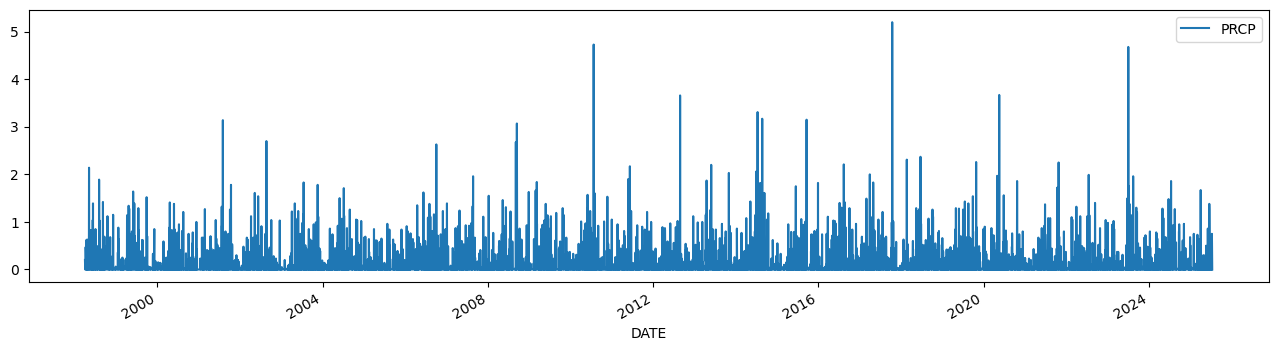

In [95]:
df_p.plot(figsize=(16,4))

In [161]:
from scipy.signal import savgol_filter

# Smoothing the data using a Savgol filter
df_smooth = df_p.copy()
df_smooth['PRCP'] = savgol_filter(df_smooth['PRCP'], 30, 3)
df_smooth

,PRCP
DATE,
1998-04-01,0.069313
1998-04-02,0.080022
1998-04-03,0.089164
1998-04-04,0.096859
1998-04-05,0.103223
...,...
2025-07-09,0.145070
2025-07-10,0.184210
2025-07-11,0.231193


<Axes: xlabel='DATE'>

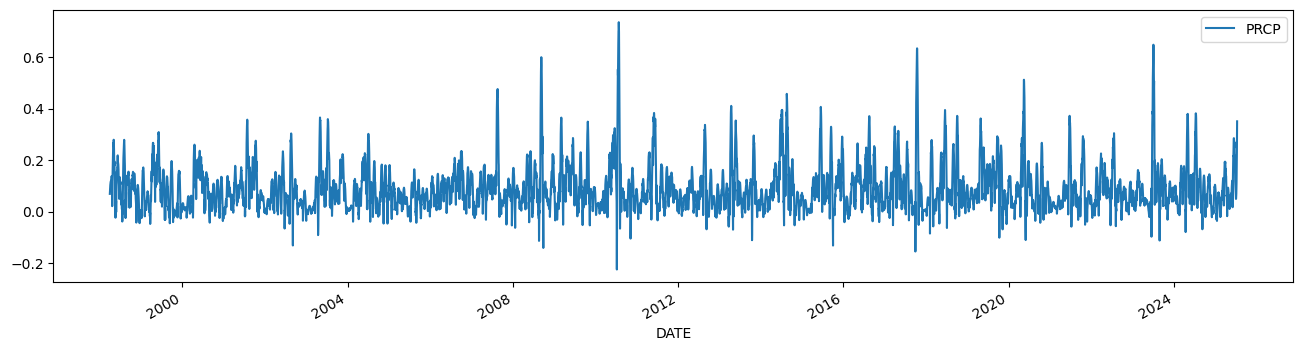

In [111]:
df_smooth.plot(figsize=(16,4))

<Axes: xlabel='DATE'>

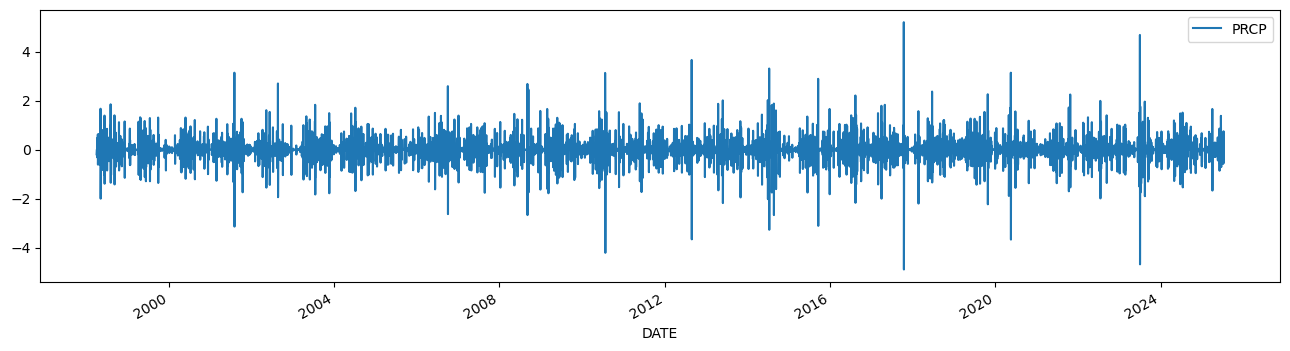

In [165]:
# Plotting the difference compared to the next element
diff_df_p = df_p.diff().dropna()
diff_df_p.plot(figsize=(16,4))

<Axes: xlabel='DATE'>

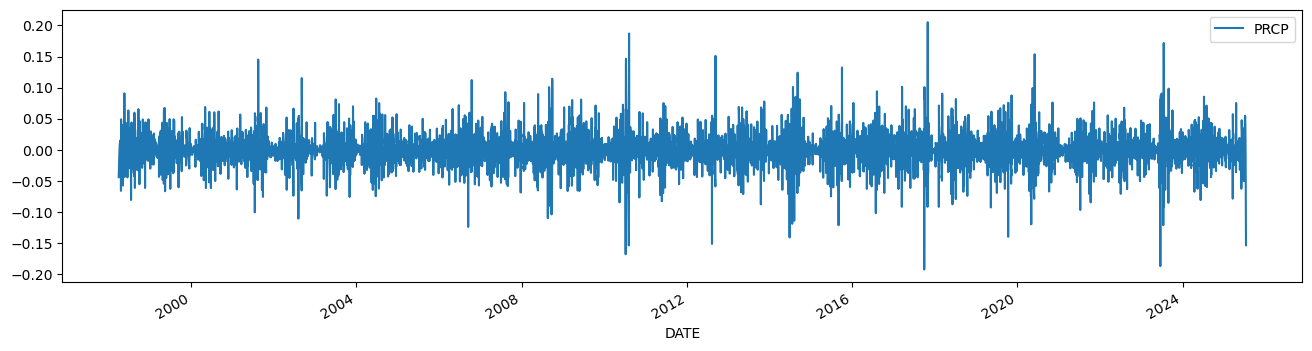

In [167]:
# Smoothing the difference plot
diff_df_smooth = diff_df_p.copy()
diff_df_smooth['PRCP'] = savgol_filter(diff_df_smooth['PRCP'], 30, 3)
diff_df_smooth.plot(figsize=(16,4))

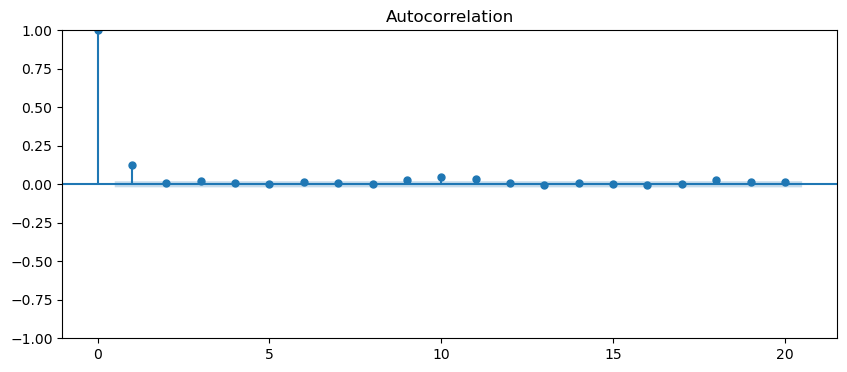

In [169]:
# Plotting autocorrelations
fig, ax = plt.subplots(figsize=(10,4))
tsaplots.plot_acf(df_p, lags=20, ax=ax)
plt.show()

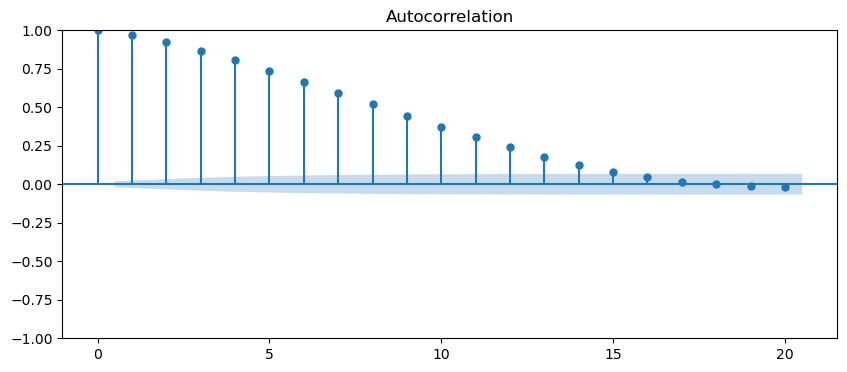

In [123]:
fig, ax = plt.subplots(figsize=(10,4))
tsaplots.plot_acf(df_smooth, lags=20, ax=ax)
plt.show()

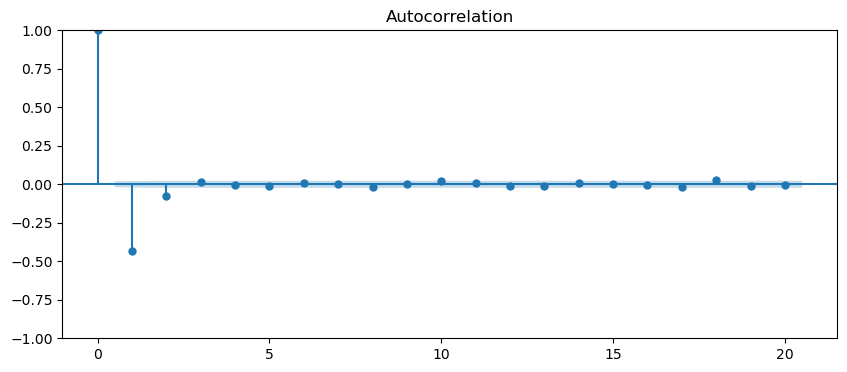

In [125]:
fig, ax = plt.subplots(figsize=(10,4))
tsaplots.plot_acf(diff_df_p, lags=20, ax=ax)
plt.show()

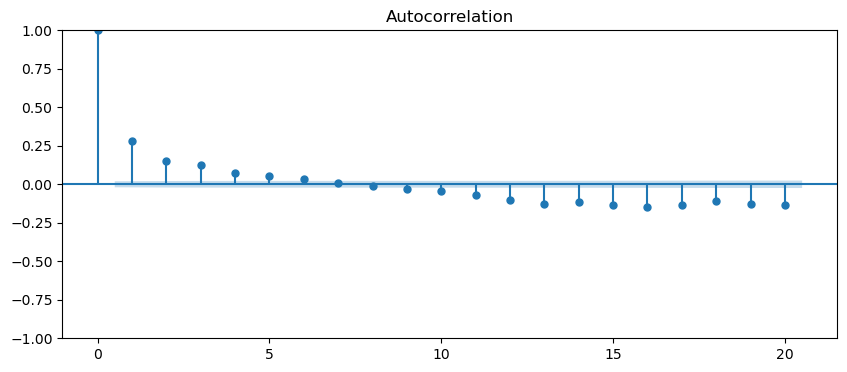

In [127]:
fig, ax = plt.subplots(figsize=(10,4))
tsaplots.plot_acf(diff_df_smooth, lags=20, ax=ax)
plt.show()

In [171]:
# Creating a sub-set of historical data
y_hist = df_p.loc['2012':'2024', 'PRCP']
y_hist

DATE
2012-01-01    0.02
2012-01-02    0.00
2012-01-03    0.00
2012-01-04    0.00
2012-01-05    0.00
              ... 
2024-12-27    0.19
2024-12-28    0.01
2024-12-29    0.68
2024-12-30    0.00
2024-12-31    0.51
Name: PRCP, Length: 4732, dtype: float64

In [173]:
# Creating future data w.r.t. the above historic slice
y_future = df_p.loc['2025', 'PRCP']
y_future

DATE
2025-01-01    0.00
2025-01-02    0.00
2025-01-03    0.00
2025-01-04    0.00
2025-01-05    0.01
              ... 
2025-07-09    0.00
2025-07-10    0.75
2025-07-11    0.54
2025-07-12    0.01
2025-07-13    0.00
Name: PRCP, Length: 194, dtype: float64

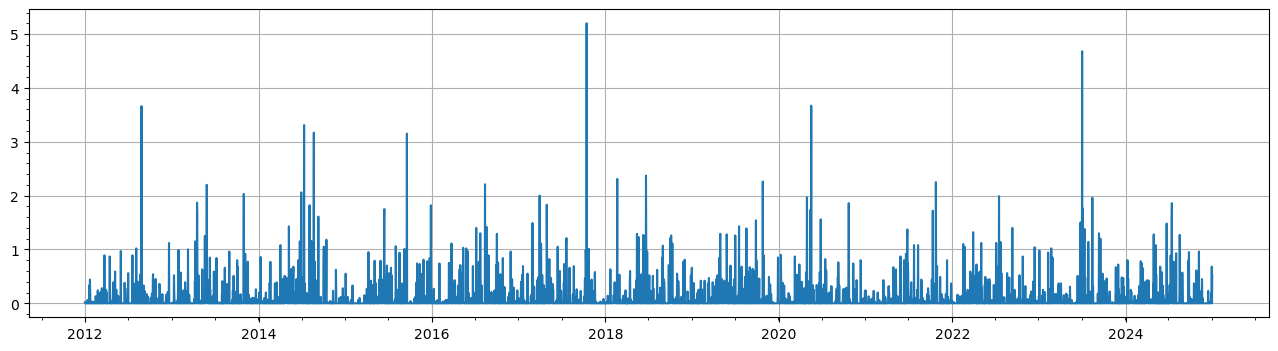

In [133]:
plt.figure(figsize=(16,4))
plt.grid()
plt.minorticks_on()
plt.plot(y_hist)

In [175]:
# Creating list of indices marking January 1st of each year
new_year_indexes = [0, 364, 729, 1093, 1457, 1823, 2183, 2548, 2911, 3276, 3637, 4002, 4366]
new_year_dates = y_hist.index[new_year_indexes]
new_year_dates

DatetimeIndex(['2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01',
               '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01',
               '2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01',
               '2024-01-01'],
              dtype='datetime64[ns]', name='DATE', freq=None)

In [177]:
# Splitting data into chunks of even seasons
period = 365
num_seasons = 12

seasonals = np.empty((period, num_seasons))
for p in range(num_seasons):
    s = y_hist[new_year_indexes[p]:new_year_indexes[p]+period]
    s = 2*(s-np.min(s))/(np.max(s)-np.min(s))
    seasonals[:,p] = s

mean_seasonals = seasonals.mean(axis=1)

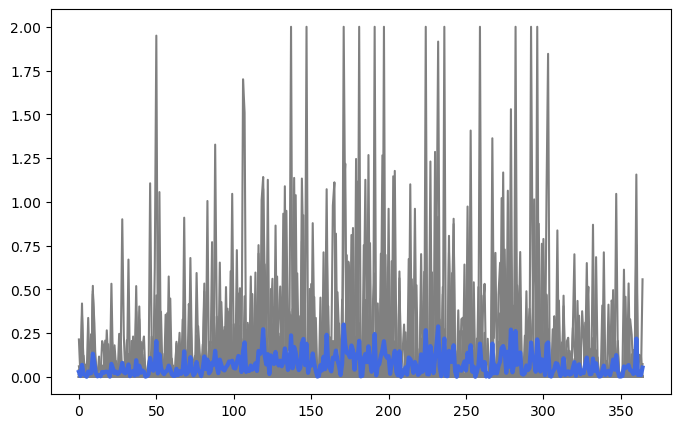

In [179]:
# Plotting each season overlayed on top of each other, with mean value marked in blue
plt.figure(figsize=(8,5))
for p in range(num_seasons):
    plt.plot(seasonals[:,p], color=0.5*np.ones(3))
plt.plot(mean_seasonals, color='royalblue', linewidth=3)

In [181]:
# Smoothing seasonal data with convolutional filter
filt_size = 9
filt = np.repeat(1.0 / filt_size, filt_size)

seasonals = np.empty((period, num_seasons))
for p in range(num_seasons):
    s = y_hist[new_year_indexes[p]:new_year_indexes[p]+period]
    s = convolution_filter(s, filt)
    s = _extrapolate_trend(s, filt_size)
    s = 2*(s-np.min(s))/(np.max(s)-np.min(s))
    seasonals[:,p] = s

mean_seasonals = seasonals.mean(axis=1)

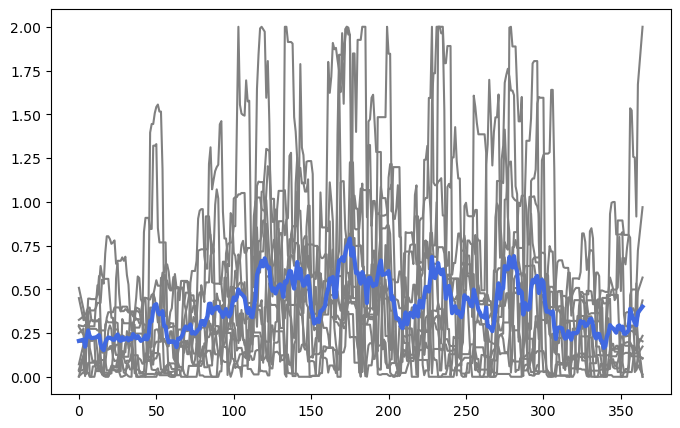

In [183]:
plt.figure(figsize=(8,5))
for p in range(num_seasons):
    plt.plot(seasonals[:,p], color=0.5*np.ones(3))
plt.plot(mean_seasonals, color='royalblue', linewidth=3)

In [185]:
# Copying seasonal mean for every season in data slice
seasonal = pd.Series(index=y_hist.index, data=0)

for low in new_year_indexes:
    if low+period<len(seasonal):
        seasonal[low:low+period] = mean_seasonals
    else:
        seasonal[low:] = mean_seasonals[:len(seasonal)-(low+period)]
        
seasonal = seasonal / np.max(seasonal)

C:\Users\Brian\AppData\Local\Temp\ipykernel_11048\1594152337.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.20514136 0.20748474 0.20982811 0.21217149 0.17206335 0.22569547
 0.26500503 0.22998165 0.22142633 0.22187598 0.22328741 0.22515719
 0.23050294 0.23780803 0.18733023 0.16165426 0.15212447 0.19398692
 0.21475109 0.22422835 0.22305107 0.21787047 0.21113375 0.21188019
 0.23022583 0.24167025 0.20959389 0.20539913 0.22584906 0.21132617
 0.2157788  0.22319826 0.20763942 0.22058204 0.2156067  0.24396348
 0.23288379 0.21976785 0.23257275 0.22006724 0.20510283 0.21119684
 0.21565831 0.23648219 0.21349229 0.23010413 0.32085359 0.31663266
 0.38304686 0.40996878 0.41517444 0.37120157 0.35613515 0.36280407
 0.375643   0.28934209 0.28694075 0.22329633 0.19629063 0.20305576
 0.19965879 0.20347203 0.19229494 0.16906213 0.21755998 0.21620832
 0.22511254 0.24087834 0.27304793 0.28717767 0.27528041 0.27346118


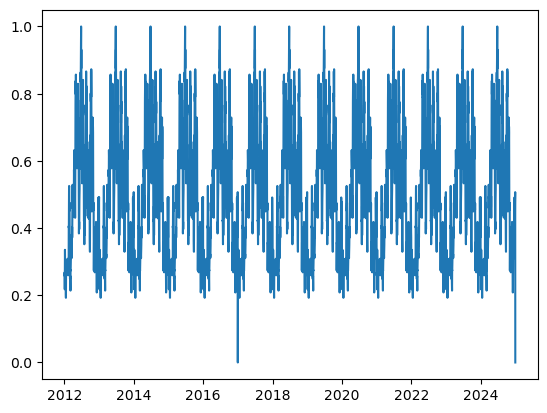

In [147]:
plt.plot(seasonal)

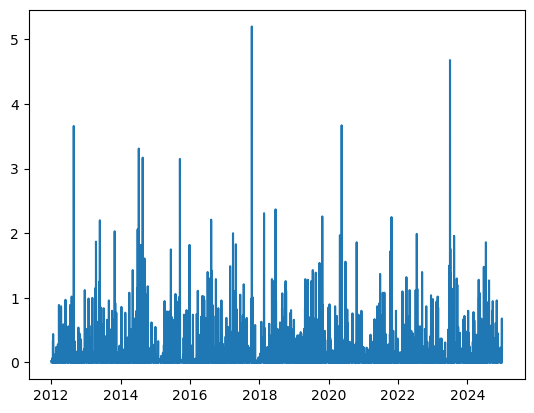

In [149]:
plt.plot(y_hist)

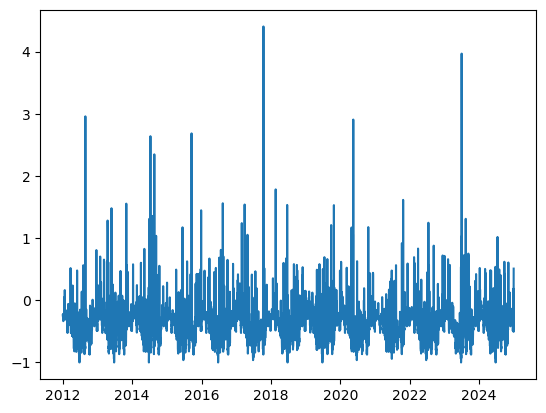

In [187]:
# Residual after subtracting seasonal averages from data
residue = y_hist - seasonal
plt.plot(residue)

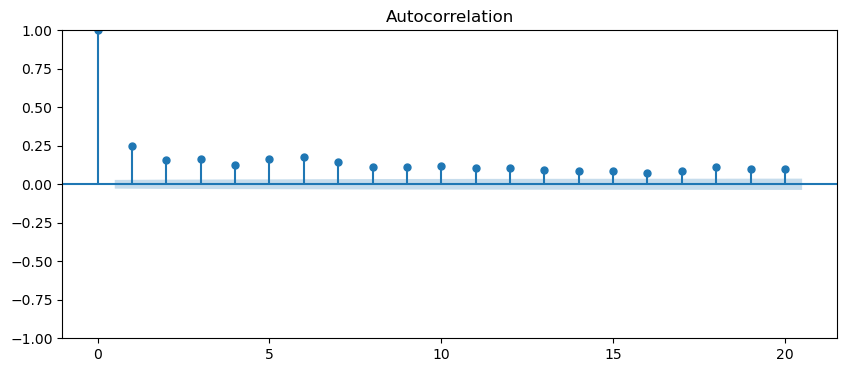

In [153]:
_, ax = plt.subplots(figsize=(10,4))
tsaplots.plot_acf(residue,lags=20, ax=ax)
plt.show()

In [189]:
# Creating forecast based on historical data
yhat_seasonal = pd.Series(index=y_future.index)
for i in range(len(yhat_seasonal)):
    yhat_seasonal[i] = seasonal[-(2*len(mean_seasonals)-i)]

C:\Users\Brian\AppData\Local\Temp\ipykernel_11048\1445584380.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat_seasonal[i] = seasonal[-(2*len(mean_seasonals)-i)]
C:\Users\Brian\AppData\Local\Temp\ipykernel_11048\1445584380.py:4: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  yhat_seasonal[i] = seasonal[-(2*len(mean_seasonals)-i)]


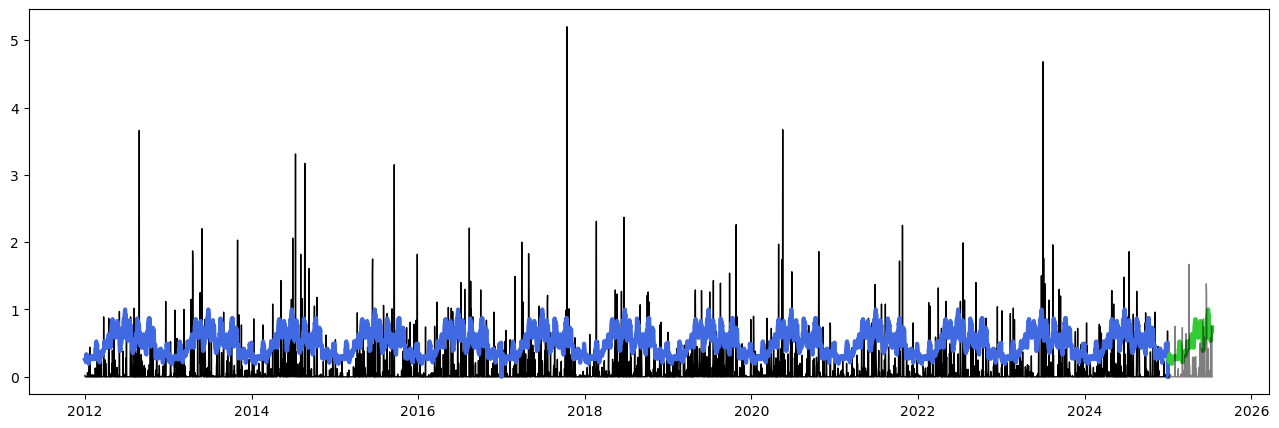

In [157]:
plt.figure(figsize=(16,5))
plt.plot(y_hist,'k',label='data',linewidth=1)
plt.plot(seasonal,label='model',color='royalblue',linewidth=3)
plt.plot(yhat_seasonal,label='forecast',color='limegreen',linewidth=3)
plt.plot(y_future,'k',alpha=0.5,linewidth=1)